### Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import pyreadr
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from numpy import linalg as LA

### Spreads

$\frac{dS^i}{S^i} = \sum_{l} \beta_{i,l} \frac{dI^l}{I^l} + dZ^i$

In [4]:
# file path for SP500 price data
filepath = 'data/sp500_data.csv'
df = pd.read_csv(filepath)

df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.set_index('date',inplace=True)

In [5]:
# 442 stock returns over 5 years - 1258 days
print('shape: {}'.format(df.shape))
# last date
print('last date: {}'.format(df.index[-1]))

shape: (1259, 442)
last date: 2019-10-04


In [12]:
# get rid of _price, change to pct and clean
col_list = []
for i in df.columns:
    col_list.append(i.split('_', 1)[0])
df.columns = col_list

# df = df.pct_change()
df = df.dropna(axis=0)
df = df.apply(np.log)

In [7]:
import glob

path = '/Users/zachariemartin/Desktop/School/Projects/summer2019/2/sum19/data/etf data'
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df_ = pd.read_csv(filename, usecols=[4], header='infer')
    li.append(df_)

etf_df = pd.concat(li, axis=1, ignore_index=True)

In [14]:
# etf_df = etf_df.pct_change()
etf_df = etf_df.dropna(axis=0)
etf_df = etf_df.apply(np.log)

In [15]:
# 9 etf prices over 5 years - 1258 days
x = etf_df.values
x.shape

(1259, 9)

In [16]:
# throw out intercept

from sklearn import linear_model

# regress on each stocks returns, save residuals
reg = linear_model.LinearRegression(fit_intercept=False)
x = etf_df.values 
df_residuals = pd.DataFrame(columns=df.columns)

for i in range(df.shape[1]):
    y = df.iloc[:,i].values.reshape(-1,1)
    reg.fit(x,y)
    w = reg.coef_
    b = reg.intercept_
    df_residuals.iloc[:,i] = (y-(x@w.T + b)).flatten()

In [17]:
# compare this cell and the one below
df_residuals.head()

,AAPL,ACN,AMG,AMT,ANTM,BBBY,BK,CAH,DE,DLTR,...,MLM,MSFT,NFLX,O,PCAR,SRCL,TGNA,TXT,V,WU
0,-0.127342,-0.024653,-0.072341,0.094726,0.060559,-0.170857,0.006836,-0.024728,0.075087,-0.105760,...,-0.049610,0.094355,0.191398,-0.071986,-0.049101,-0.100655,-0.006409,-0.193394,-0.071580,-0.157120
1,-0.121058,-0.032366,-0.044049,0.087800,0.076969,-0.161627,0.013857,-0.016477,0.073494,-0.085257,...,-0.064415,0.094331,0.223313,-0.073961,-0.058400,-0.105653,-0.031672,-0.193046,-0.075880,-0.174416
2,-0.131406,-0.035726,-0.032336,0.076120,0.054584,-0.127918,0.011043,0.005859,0.056233,-0.080951,...,-0.062342,0.094706,0.220633,-0.065801,-0.046429,-0.080344,-0.028873,-0.195051,-0.080290,-0.153289
3,-0.105988,-0.042224,-0.019992,0.085088,0.081791,-0.094212,0.006045,0.003051,0.086197,-0.072414,...,-0.066818,0.086111,0.237953,-0.045558,-0.041192,-0.055723,-0.067807,-0.193638,-0.087315,-0.175112
4,-0.074747,-0.045782,-0.031493,0.096143,0.079406,-0.160485,-0.001003,-0.015476,0.105027,-0.077862,...,-0.115026,0.079713,0.253090,-0.054570,-0.051749,-0.098294,-0.114220,-0.179744,-0.078727,-0.183665


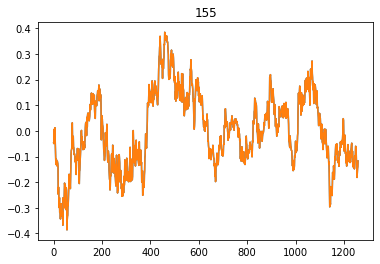

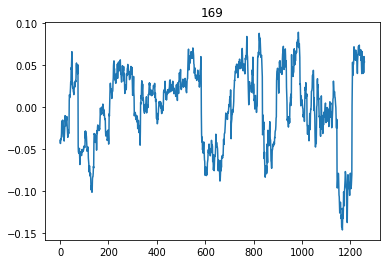

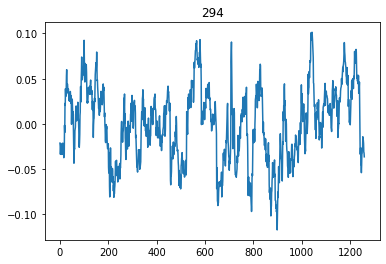

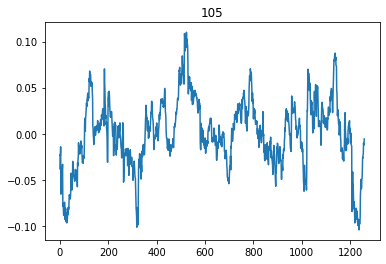

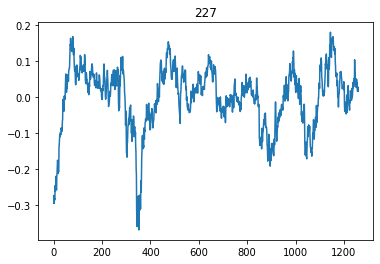

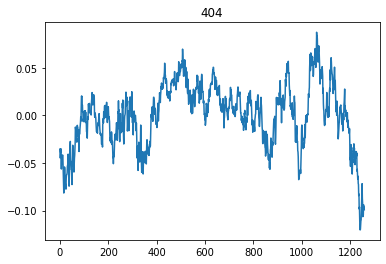

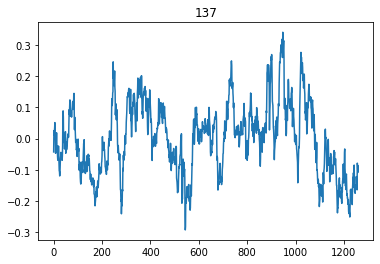

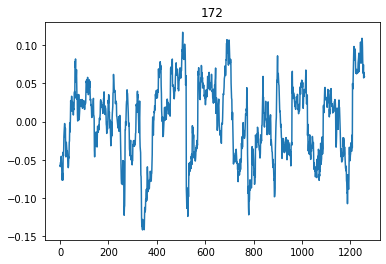

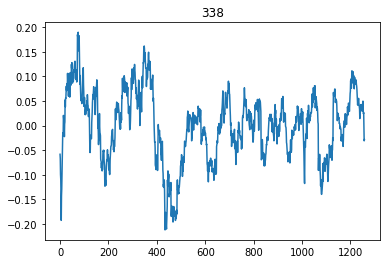

In [18]:
#compare 10 random plots
x = np.random.randint(low=0,high=df_residuals.shape[1],size=10)

if True:
    for i in x:
        plt.figure(i)
        plt.plot(df_residuals.iloc[:,i])
        plt.title(i)
        plt.savefig('non-integrated.png')

In [19]:
# compare this cell and the one above
# df_residuals_cumsum = df_residuals.cumsum(axis=0)
# df_residuals_cumsum.head()

In [20]:
#compare 40 plots
# x = np.random.randint(low=0,high=df_residuals.shape[1],size=1)

if False:
    for i in x:
        plt.figure(i)
        plt.plot(df_residuals_cumsum.iloc[:,i])
        plt.title(i)
        plt.savefig('integrated.png')

In [13]:
df_residuals.set_index(df.index,inplace=True)

In [22]:
from statsmodels.tsa.stattools import adfuller

df_df = pd.DataFrame(columns=['ADF Statistic','p-value','n lags used'],index=df_residuals.columns)

# test "integrated" residuals for stationarity and return adf statistic and p-value, columns 0 and 1 respectively
for i in range(df_residuals.shape[1]):
    result = adfuller(df_residuals.iloc[:,i])
    df_df.iloc[i,0] = result[0]
    df_df.iloc[i,1] = result[1]
    df_df.iloc[i,2] = result[2]


In [38]:
# check for significance at 5% level - remove residual times series that don't pass test
drop_arr = np.where(df_df.iloc[:,1] > .05)
df_residuals = df_residuals.drop(df_residuals.columns.values[drop_arr[0]], axis=1)

In [24]:
df_df

,ADF Statistic,p-value,n lags used
AAPL,-4.16249,0.000762133,0
ACN,-3.49114,0.00821751,3
AMG,-4.09819,0.000975236,0
AMT,-4.78558,5.7949e-05,0
ANTM,-4.42285,0.000270377,0
BBBY,-4.36608,0.000340667,0
BK,-3.30845,0.014505,0
CAH,-5.75757,5.77206e-07,1
DE,-4.65354,0.000102793,1
DLTR,-3.6608,0.00469955,0


In [ ]:
# y <- audnzd # Forex Australian Dollar/New Zealand Dollar
# y.lag <- lag(y, -1)
# delta.y <- diff(y)

# df <- cbind(y, y.lag, delta.y)
# df <- df[-1 ,] #remove first row with NAs

# regress.results <- lm(delta.y ~ y.lag, data = df)

# lambda <- summary(regress.results)$coefficients[2]

In [82]:
# compute speed of mean reversion
df_residuals_lag = pd.DataFrame(np.roll(df_residuals,-1,axis=0)).drop(index=0,axis=0)

In [50]:
df_residuals_diff = df_residuals.diff().drop(index=0,axis=0)

In [89]:
df_residuals_diff.head()

,AAPL,ACN,AMG,AMT,ANTM,BBBY,BK,CAH,DE,DLTR,...,MLM,MSFT,NFLX,O,PCAR,SRCL,TGNA,TXT,V,WU
1,0.006284,-0.007712,0.028292,-0.006926,0.016410,0.009230,0.007021,0.008251,-0.001592,0.020503,...,-0.014805,-0.000024,0.031915,-0.001975,-0.009299,-0.004998,-0.025262,0.000348,-0.004301,-0.017296
2,-0.010348,-0.003361,0.011713,-0.011680,-0.022385,0.033709,-0.002814,0.022336,-0.017261,0.004306,...,0.002073,0.000375,-0.002680,0.008160,0.011971,0.025309,0.002799,-0.002005,-0.004409,0.021126
3,0.025419,-0.006497,0.012344,0.008967,0.027207,0.033706,-0.004998,-0.002808,0.029963,0.008537,...,-0.004476,-0.008596,0.017320,0.020243,0.005237,0.024620,-0.038934,0.001414,-0.007025,-0.021822
4,0.031240,-0.003558,-0.011501,0.011055,-0.002386,-0.066273,-0.007048,-0.018527,0.018830,-0.005448,...,-0.048208,-0.006397,0.015138,-0.009013,-0.010557,-0.042571,-0.046412,0.013894,0.008588,-0.008553
5,0.013643,0.005147,0.048729,-0.019160,-0.001768,0.042358,0.002231,0.018978,0.018732,0.022029,...,-0.030635,-0.017871,-0.019223,-0.008773,-0.003321,0.075920,-0.009330,-0.000423,0.004150,0.007158


In [100]:
# regress diff on to lag
slope_array = np.zeros((df_residuals_diff.shape[1],5))
for i in range(df_residuals_diff.shape[1]):
    slope_array[i] = linregress(df_residuals_diff.iloc[:,i],df_residuals_lag.iloc[:,i])

In [103]:
slope_array[0]

array([ 5.13963612e-01, -1.33326718e-06,  1.18282727e-01,  2.60058279e-05,
        1.21746562e-01])

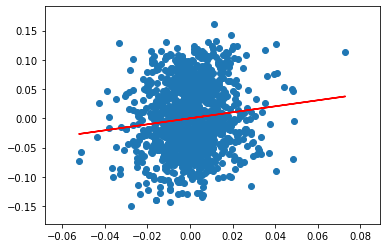

In [120]:
plt.scatter(x=df_residuals_diff.iloc[:,0],y=df_residuals_lag.iloc[:,0])
plt.plot(df_residuals_diff.iloc[:,0], slope_array[0,0] * df_residuals_diff.iloc[:,0] + slope_array[0,1],c='r')

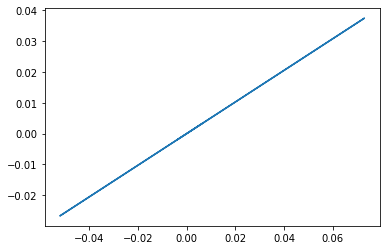

In [104]:
slope_array[0,0]*df_residuals_diff.iloc[:,0] - df_residuals_lag.iloc[:,0] + slope_array[0,1]

1       0.134634
2       0.100668
3       0.087810
4       0.077160
5       0.050840
6       0.048603
7       0.036308
8       0.034717
9       0.025844
10      0.036303
11      0.020481
12      0.018714
13      0.035621
14      0.019406
15      0.025759
16      0.027897
17      0.038479
18      0.047226
19      0.039134
20      0.061689
21      0.047610
22      0.048616
23      0.041164
24      0.051253
25      0.036659
26      0.030120
27      0.026325
28      0.013080
29      0.015296
30      0.008245
          ...   
1229   -0.052668
1230   -0.047445
1231   -0.060527
1232   -0.051777
1233   -0.053713
1234   -0.058609
1235   -0.055072
1236   -0.050487
1237   -0.053875
1238   -0.066077
1239   -0.078803
1240   -0.092382
1241   -0.086062
1242   -0.088105
1243   -0.086360
1244   -0.085578
1245   -0.090056
1246   -0.068684
1247   -0.075913
1248   -0.072290
1249   -0.085550
1250   -0.085815
1251   -0.094791
1252   -0.107812
1253   -0.112691
1254   -0.125961
1255   -0.125810
1256   -0.1177

In [25]:
# save results to csv
path = 'data/zprocess_data.csv'
df_residuals.to_csv(path)

In [18]:
# plot spreads
# df_z = pd.read_csv('/Users/zachariemartin/Desktop/School/Projects/summer2019/2/sum19/data/zprocess_data.csv')

In [27]:
# plt.plot(df_z.iloc[:,1])

In [26]:
# plot "returns" to see if they make sense   
if False:
    for i in range(1,10):
        plt.figure(i)
        plt.plot(df_z.iloc[:,i])